## Work
* 請比較使用 l1, l1_l2 及不同比例下的訓練結果
* 了解如何在 Keras 中，加入 regularization
* 熟悉建立、訓練模型
* 熟悉將訓練結果視覺化並比較結果

In [2]:
import os
import keras

# 本範例不需使用 GPU, 將 GPU 設定為 "無"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [3]:
# 從 Keras 的內建功能中，取得 train 與 test 資料集
train, test = keras.datasets.cifar10.load_data()

In [4]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [5]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

def build_mlpL1(input_shape, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l1(l1_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l1(l1_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

In [8]:
results = {}

#loop for L2
for regulizer_ratio in L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], l2_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "L2_exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


W0724 14:47:00.981541 4442342848 deprecation_wrapper.py:119] From /Users/vincent/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0724 14:47:00.982625 4442342848 deprecation_wrapper.py:119] From /Users/vincent/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0724 14:47:01.004106 4442342848 deprecation_wrapper.py:119] From /Users/vincent/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0724 14:47:01.005124 4442342848 deprecation_wrapper.py:119] From /Users/vincent/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.

Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


W0724 14:47:01.236525 4442342848 deprecation.py:323] From /Users/vincent/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 73us/step - loss: 15.0777 - acc: 0.2730 - val_loss: 13.9441 - val_acc: 0.3445
Epoch 2/50
50000/50000 [==============================] - 4s 74us/step - loss: 13.0104 - acc: 0.3607 - val_loss: 12.1176 - val_acc: 0.3722
Epoch 3/50
50000/50000 [==============================] - 4s 81us/step - loss: 11.3340 - acc: 0.3862 - val_loss: 10.5868 - val_acc: 0.3954
Epoch 4/50
50000/50000 [==============================] - 4s 73us/step - loss: 9.9203 - acc: 0.3978 - val_loss: 9.2892 - val_acc: 0.4030
Epoch 5/50
50000/50000 [==============================] - 4s 75us/step - loss: 8.7195 - acc: 0.4116 - val_loss: 8.1751 - val_acc: 0.4135
Epoch 6/50
50000/50000 [==============================] - 4s 75us/step - loss: 7.6970 - acc: 0.4195 - val_loss: 7.2360 - val_acc: 0.4214
Epoch 7/50
50000/50000 [==============================] - 4s 76us/step - loss: 6.8246 - acc: 0.4271 - val_loss: 6.4306 - v

50000/50000 [==============================] - 4s 78us/step - loss: 1.9309 - acc: 0.3746 - val_loss: 1.8857 - val_acc: 0.3916
Epoch 3/50
50000/50000 [==============================] - 4s 79us/step - loss: 1.8520 - acc: 0.4006 - val_loss: 1.8276 - val_acc: 0.4062
Epoch 4/50
50000/50000 [==============================] - 4s 80us/step - loss: 1.7958 - acc: 0.4197 - val_loss: 1.7782 - val_acc: 0.4189
Epoch 5/50
50000/50000 [==============================] - 4s 78us/step - loss: 1.7506 - acc: 0.4346 - val_loss: 1.7414 - val_acc: 0.4342
Epoch 6/50
50000/50000 [==============================] - 4s 77us/step - loss: 1.7127 - acc: 0.4481 - val_loss: 1.7115 - val_acc: 0.4435
Epoch 7/50
50000/50000 [==============================] - 4s 74us/step - loss: 1.6802 - acc: 0.4601 - val_loss: 1.6825 - val_acc: 0.4547
Epoch 8/50
50000/50000 [==============================] - 4s 76us/step - loss: 1.6498 - acc: 0.4692 - val_loss: 1.6566 - val_acc: 0.4632
Epoch 9/50
50000/50000 [============================

50000/50000 [==============================] - 4s 74us/step - loss: 1.7326 - acc: 0.3928 - val_loss: 1.7110 - val_acc: 0.4010
Epoch 4/50
50000/50000 [==============================] - 4s 75us/step - loss: 1.6749 - acc: 0.4121 - val_loss: 1.6588 - val_acc: 0.4167
Epoch 5/50
50000/50000 [==============================] - 4s 76us/step - loss: 1.6278 - acc: 0.4305 - val_loss: 1.6181 - val_acc: 0.4320
Epoch 6/50
50000/50000 [==============================] - 4s 75us/step - loss: 1.5899 - acc: 0.4435 - val_loss: 1.5985 - val_acc: 0.4378
Epoch 7/50
50000/50000 [==============================] - 4s 75us/step - loss: 1.5567 - acc: 0.4560 - val_loss: 1.5534 - val_acc: 0.4559
Epoch 8/50
50000/50000 [==============================] - 4s 73us/step - loss: 1.5276 - acc: 0.4659 - val_loss: 1.5531 - val_acc: 0.4542
Epoch 9/50
50000/50000 [==============================] - 4s 73us/step - loss: 1.5011 - acc: 0.4754 - val_loss: 1.5167 - val_acc: 0.4691
Epoch 10/50
50000/50000 [===========================

50000/50000 [==============================] - 4s 75us/step - loss: 1.6580 - acc: 0.4202 - val_loss: 1.6370 - val_acc: 0.4312
Epoch 5/50
50000/50000 [==============================] - 4s 74us/step - loss: 1.6098 - acc: 0.4373 - val_loss: 1.5989 - val_acc: 0.4418
Epoch 6/50
50000/50000 [==============================] - 4s 74us/step - loss: 1.5708 - acc: 0.4489 - val_loss: 1.5730 - val_acc: 0.4486
Epoch 7/50
50000/50000 [==============================] - 4s 73us/step - loss: 1.5377 - acc: 0.4612 - val_loss: 1.5437 - val_acc: 0.4562
Epoch 8/50
50000/50000 [==============================] - 4s 85us/step - loss: 1.5060 - acc: 0.4726 - val_loss: 1.5318 - val_acc: 0.4561
Epoch 9/50
50000/50000 [==============================] - 4s 85us/step - loss: 1.4790 - acc: 0.4807 - val_loss: 1.5085 - val_acc: 0.4656
Epoch 10/50
50000/50000 [==============================] - 4s 81us/step - loss: 1.4548 - acc: 0.4910 - val_loss: 1.4921 - val_acc: 0.4713
Epoch 11/50
50000/50000 [==========================

In [10]:
#loop for L1
for regulizer_ratio in L2_EXP:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f" % (regulizer_ratio))
    model = build_mlpL1(input_shape=x_train.shape[1:], l1_ratio=regulizer_ratio)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "L1_exp-l2-%s" % str(regulizer_ratio)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with Regulizer = 0.010000
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 4s 84us/step - loss: 6.0020 - acc: 0.2746 - val_loss: 5.8072 - val_acc: 0.3486
Epoch 2/50
50000/50000 [==============================] - 4s 79us/step - loss: 5.7165 - acc: 0.3669 - val_loss: 5.6365 - val_acc: 0.3844
Epoch 3/50
50000/50000 [==============================] - 4s 79us/step - loss: 5.5689 - acc: 0.3982 - val_loss: 5.5119 - val_acc: 0.4100
Epoch 4/50
50000/50000 [==============================] - 4s 78us/step - loss: 5.4422 - acc: 0.4188 - val_loss: 5.3998 - val_acc: 0.4229
Epoch 5/50
50000/50000 [==============================] - 4s 76us/step - loss: 5.3313 - acc: 0.4377 - val_loss: 5.2881 - val_acc: 0.4390
Epoch 6/50
50000/50000 [==============================] - 4s 75us/step - loss: 5.2311 - acc: 0.4479 - val_loss: 5.1941 - val_acc: 0.4539
Epoch 7/50
50000/50000 [==============================] - 4s 76us/step - loss: 5.1378 - acc: 0.4593 - val_loss: 5.1119 - val_acc

50000/50000 [==============================] - 4s 72us/step - loss: 1.7830 - acc: 0.3720 - val_loss: 1.7319 - val_acc: 0.3938
Epoch 3/50
50000/50000 [==============================] - 4s 73us/step - loss: 1.6994 - acc: 0.4035 - val_loss: 1.6613 - val_acc: 0.4185
Epoch 4/50
50000/50000 [==============================] - 4s 74us/step - loss: 1.6394 - acc: 0.4264 - val_loss: 1.6207 - val_acc: 0.4307
Epoch 5/50
50000/50000 [==============================] - 4s 80us/step - loss: 1.5947 - acc: 0.4414 - val_loss: 1.5905 - val_acc: 0.4387
Epoch 6/50
50000/50000 [==============================] - 4s 73us/step - loss: 1.5580 - acc: 0.4540 - val_loss: 1.5581 - val_acc: 0.4507
Epoch 7/50
50000/50000 [==============================] - 4s 75us/step - loss: 1.5279 - acc: 0.4639 - val_loss: 1.5419 - val_acc: 0.4544
Epoch 8/50
50000/50000 [==============================] - 4s 78us/step - loss: 1.4991 - acc: 0.4749 - val_loss: 1.5167 - val_acc: 0.4634
Epoch 9/50
50000/50000 [============================

50000/50000 [==============================] - 4s 77us/step - loss: 1.7231 - acc: 0.3964 - val_loss: 1.7037 - val_acc: 0.4071
Epoch 4/50
50000/50000 [==============================] - 4s 76us/step - loss: 1.6663 - acc: 0.4178 - val_loss: 1.6515 - val_acc: 0.4215
Epoch 5/50
50000/50000 [==============================] - 4s 76us/step - loss: 1.6193 - acc: 0.4341 - val_loss: 1.6224 - val_acc: 0.4288
Epoch 6/50
50000/50000 [==============================] - 4s 79us/step - loss: 1.5813 - acc: 0.4455 - val_loss: 1.5821 - val_acc: 0.4386
Epoch 7/50
50000/50000 [==============================] - 4s 82us/step - loss: 1.5468 - acc: 0.4568 - val_loss: 1.5545 - val_acc: 0.4517
Epoch 8/50
50000/50000 [==============================] - 4s 81us/step - loss: 1.5174 - acc: 0.4688 - val_loss: 1.5313 - val_acc: 0.4653
Epoch 9/50
50000/50000 [==============================] - 4s 78us/step - loss: 1.4889 - acc: 0.4796 - val_loss: 1.5185 - val_acc: 0.4642
Epoch 10/50
50000/50000 [===========================

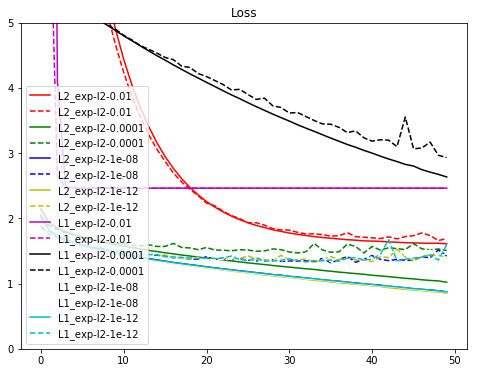

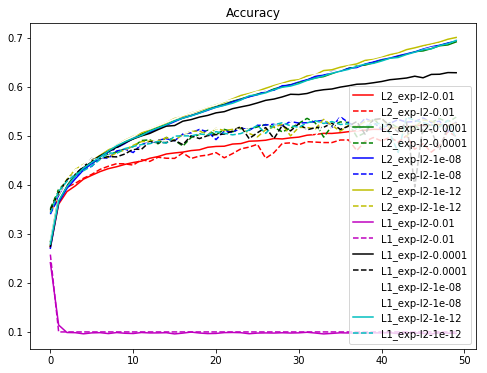

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k","w","c"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i%8])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i%8])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i%8])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i%8])
plt.title("Accuracy")
plt.legend()
plt.show()

## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果